In [1]:
from google.colab import drive # loads a library to mount your google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import models
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization ,Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.image import array_to_img
from keras.callbacks import ModelCheckpoint
import warnings
warnings.filterwarnings("ignore")
# import system libs
import os
import itertools
from PIL import Image

# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization

print ('modules loaded')

modules loaded


In [3]:
train_dir = '/content/drive/MyDrive/final_data/Training'
test_dir = '/content/drive/MyDrive/final_data/Testing'

In [4]:
def resize_and_pad_image(image):
    # Convert numpy array to TensorFlow tensor
    image = tf.convert_to_tensor(image)

    # If image is grayscale (channel size is 1), convert to RGB
    if image.shape[-1] == 1:
        image = tf.image.grayscale_to_rgb(image)

    # Resize and pad the image
    image = tf.image.resize_with_pad(image, target_height=512, target_width=512)

    return image

# All images will be rescaled by 1./255 and then resized
train_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=resize_and_pad_image)
test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=resize_and_pad_image)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(512, 512),
    batch_size=48,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(512, 512),
    batch_size=19,
    class_mode='categorical'
)
valid_generator=test_generator

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [5]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(512, 512, 3))


# Add a top / fully-connected layers
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)


# Add a logistic layer with the number of classes (assuming 4 in your case)
predictions = Dense(4, activation='softmax')(x)

# Construct the full model
model = Model(inputs=base_model.input, outputs=predictions)

87910968/87910968 [==============================] - 1s 0us/step


In [6]:
for layer in base_model.layers[:-100]:
    layer.trainable = False

# Compile the model (should be done after setting layers to non-trainable)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)

# Specify the path to save the best model weights
checkpoint_filepath = '/content/drive/MyDrive/final_data/inception_tumor_model_best_weights.h5'

In [7]:
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [8]:
history = model.fit(
    train_generator,
    steps_per_epoch=119,
    epochs=20,
    validation_data=test_generator,
    validation_steps=69, callbacks=[reduce_lr, model_checkpoint_callback])

Epoch 1/20
119/119 [==============================] - ETA: 0s - loss: 3.5461 - accuracy: 0.7404 
Epoch 1: val_accuracy improved from -inf to 0.65065, saving model to /content/drive/MyDrive/final_data/inception_tumor_model_best_weights.h5
119/119 [==============================] - 2729s 23s/step - loss: 3.5461 - accuracy: 0.7404 - val_loss: 2.8053 - val_accuracy: 0.6506 - lr: 0.0010
Epoch 2/20
119/119 [==============================] - ETA: 0s - loss: 0.2610 - accuracy: 0.9154
Epoch 2: val_accuracy improved from 0.65065 to 0.87490, saving model to /content/drive/MyDrive/final_data/inception_tumor_model_best_weights.h5
119/119 [==============================] - 264s 2s/step - loss: 0.2610 - accuracy: 0.9154 - val_loss: 0.4861 - val_accuracy: 0.8749 - lr: 0.0010
Epoch 3/20
119/119 [==============================] - ETA: 0s - loss: 0.1484 - accuracy: 0.9524
Epoch 3: val_accuracy improved from 0.87490 to 0.93898, saving model to /content/drive/MyDrive/final_data/inception_tumor_model_best_w

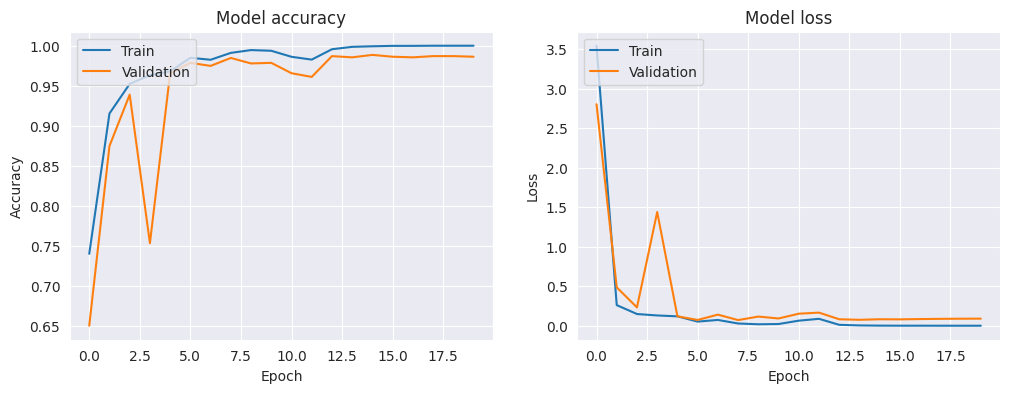

In [9]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


plt.show()

In [10]:
train_score = model.evaluate(train_generator ,  verbose = 1)
valid_score = model.evaluate(valid_generator ,  verbose = 1)
test_score = model.evaluate(test_generator ,  verbose = 1)

69/69 [==============================] - 42s 603ms/step - loss: 0.0899 - accuracy: 0.9863


In [26]:
preds = model.predict(test_generator)

y_pred = np.argmax(preds , axis = 1)


69/69 [==============================] - 40s 582ms/step


In [32]:
g_dict

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [24]:
classes

['glioma', 'meningioma', 'notumor', 'pituitary']

In [15]:
from tensorflow.keras.preprocessing.image import array_to_img

1/1 [==============================] - 0s 79ms/step
Image 1: glioma/Te-gl_0018.jpg - predicted label 1, actual label 0


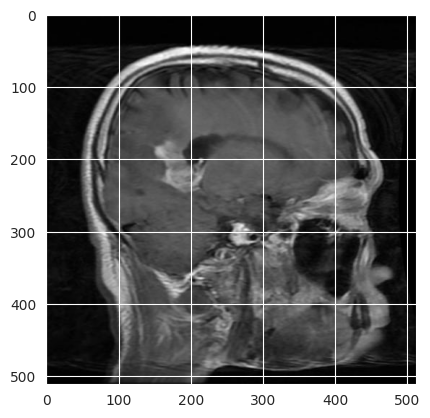

Image 2: glioma/Te-glTr_0001.jpg - predicted label 0, actual label 1


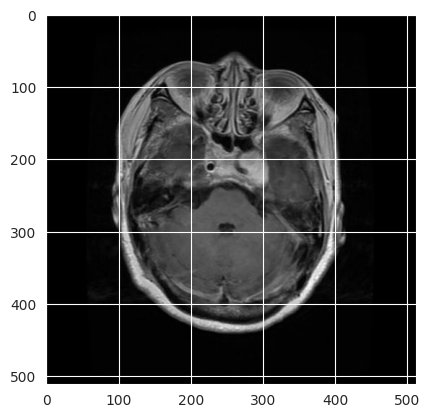

Image 3: glioma/Te-gl_0011.jpg - predicted label 3, actual label 1


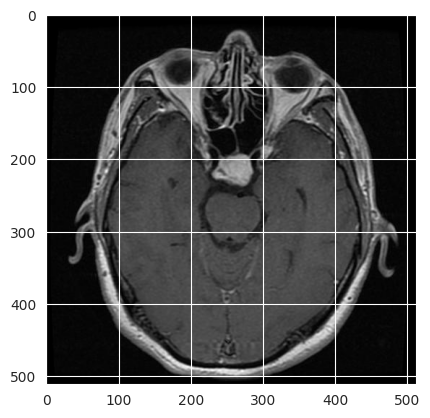

Image 4: glioma/Te-gl_0016.jpg - predicted label 1, actual label 0


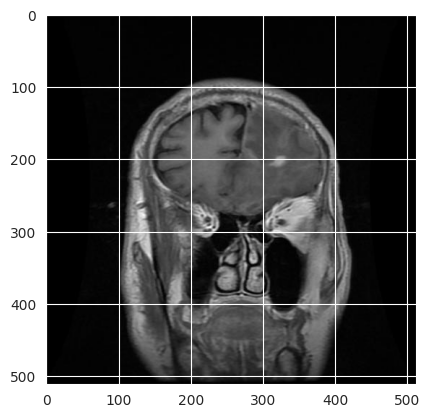

Image 5: glioma/Te-glTr_0007.jpg - predicted label 1, actual label 0


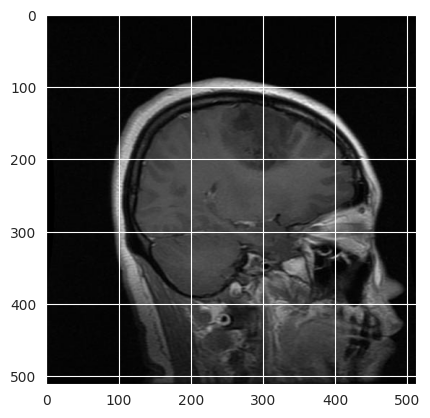

Image 6: glioma/Te-gl_0011.jpg - predicted label 1, actual label 0


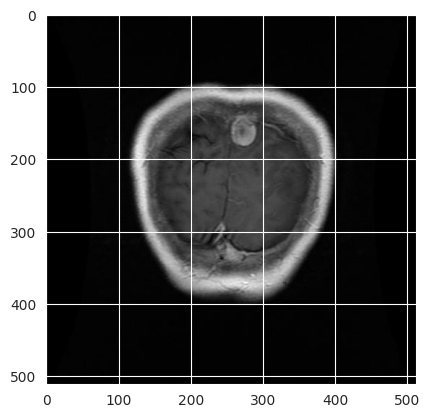

Image 7: glioma/Te-glTr_0008.jpg - predicted label 1, actual label 0


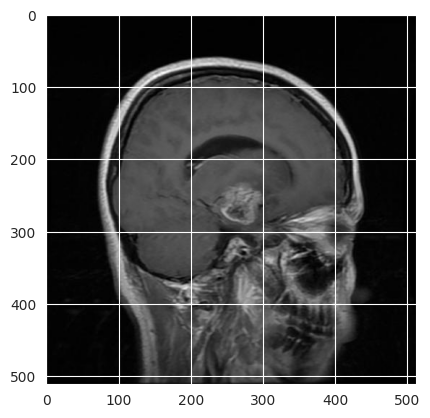

Image 8: glioma/Te-gl_0017.jpg - predicted label 1, actual label 0


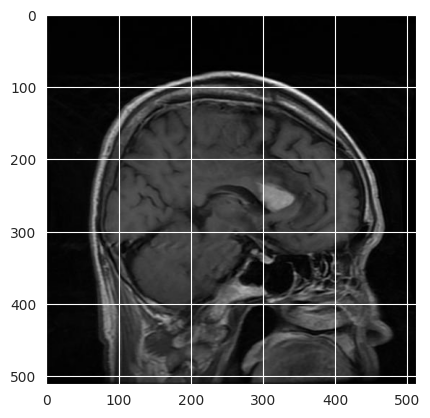

Image 9: glioma/Te-glTr_0000.jpg - predicted label 0, actual label 1


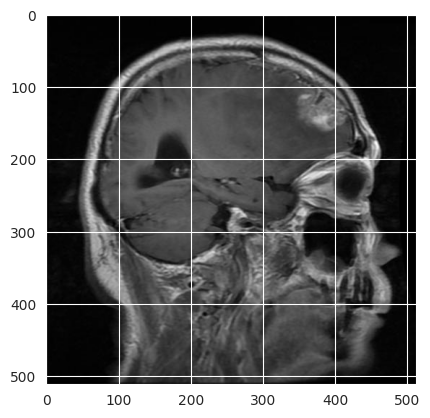

Image 10: glioma/Te-gl_0016.jpg - predicted label 2, actual label 1


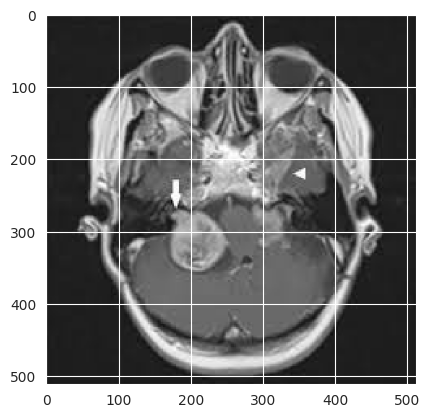

Image 11: glioma/Te-glTr_0005.jpg - predicted label 3, actual label 0


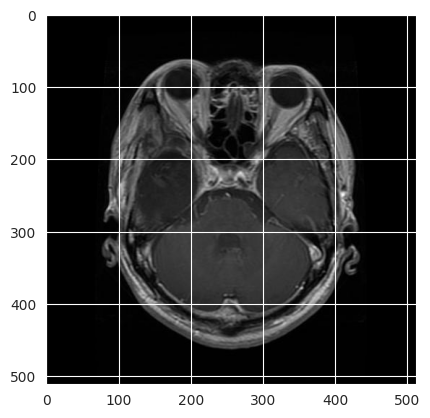

Image 12: glioma/Te-gl_0010.jpg - predicted label 1, actual label 0


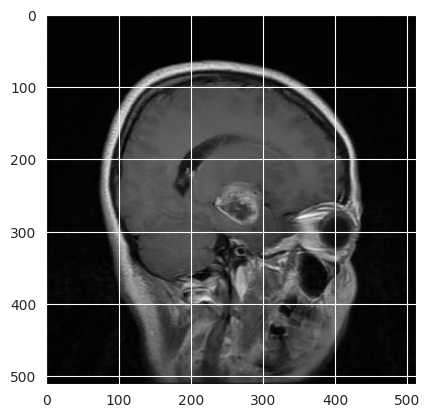

Image 13: glioma/Te-gl_0018.jpg - predicted label 2, actual label 1


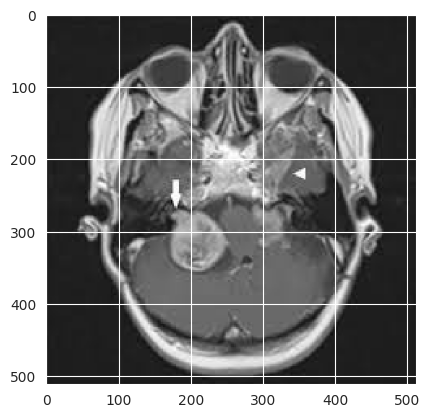

Image 14: glioma/Te-glTr_0003.jpg - predicted label 1, actual label 0


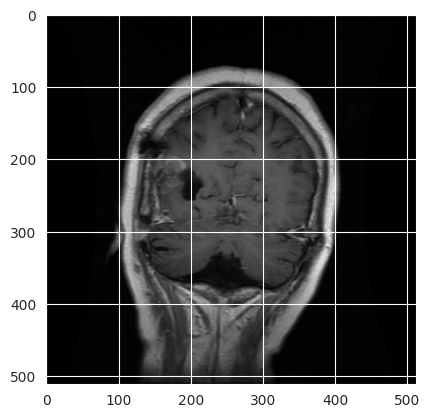

Image 15: glioma/Te-glTr_0005.jpg - predicted label 1, actual label 3


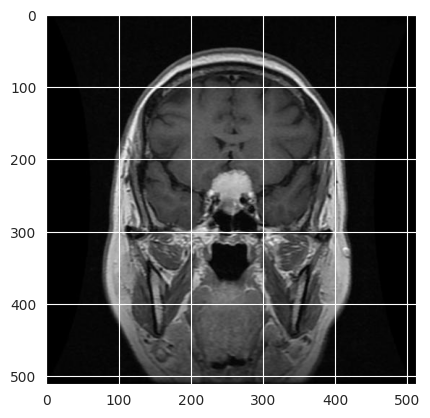

Image 16: glioma/Te-glTr_0007.jpg - predicted label 1, actual label 0


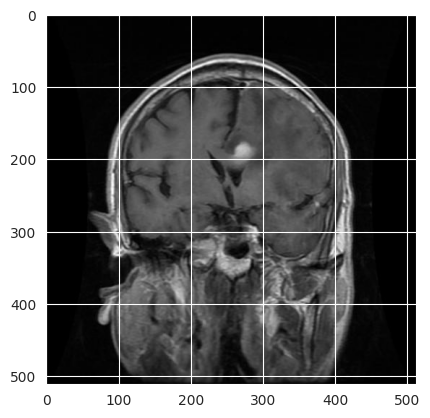

Image 17: glioma/Te-glTr_0004.jpg - predicted label 0, actual label 1


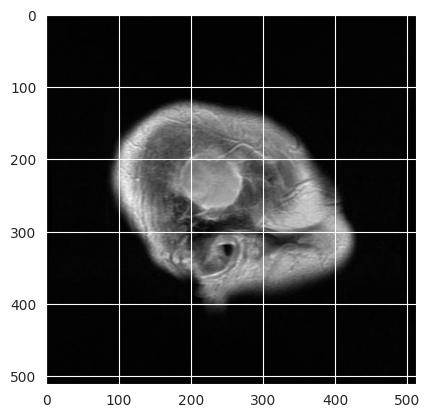

Image 18: glioma/Te-gl_0017.jpg - predicted label 1, actual label 0


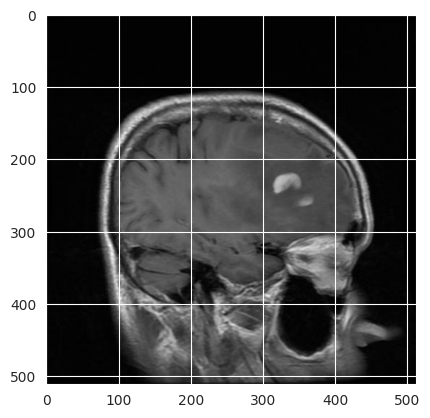

In [21]:
# Arrays to store misclassified images, predicted labels, and actual labels
misclassified_images = []
predicted_labels = []
actual_labels = []
image_names = []

# Loop over the test set
for images_batch, labels_batch in test_generator:
    # Make predictions for the current batch of images
    predictions_batch = model.predict(images_batch)
    predicted_labels_batch = np.argmax(predictions_batch, axis=1)

    # Get the actual labels
    actual_labels_batch = np.argmax(labels_batch, axis=1)
    image_names_batch = test_generator.filenames
    # Find the indices of the misclassified images
    misclassified_indices = np.where(predicted_labels_batch != actual_labels_batch)[0]

    # Store the misclassified images and their predicted and actual labels
    for i in misclassified_indices:
        misclassified_images.append(array_to_img(images_batch[i]))
        predicted_labels.append(predicted_labels_batch[i])
        actual_labels.append(actual_labels_batch[i])
        image_names.append(image_names_batch[i])

    # Stop the loop after one pass over the test set
    if test_generator.batch_index == 0:
        break

# Display the misclassified images with their predicted and actual labels
for i in range(len(misclassified_images)):
    print(f'Image {i+1}: {image_names[i]} - predicted label {predicted_labels[i]}, actual label {actual_labels[i]}')
    plt.imshow(misclassified_images[i])
    plt.show()

In [17]:
import cv2

In [19]:
model.save('/content/drive/MyDrive/final_data/Final_Inception_Brain Tumor.h5')

In [20]:
# Load the saved model
model = keras.models.load_model('/content/drive/MyDrive/final_data/Final_Inception_Brain Tumor.h5')

# Read the test image
img = cv2.imread('/content/drive/MyDrive/final_data/Testing/meningioma/Te-meTr_0001.jpg')

# Resize the image
img = cv2.resize(img, (512, 512))

# Add a batch dimension
img = np.expand_dims(img, axis=0)

# Make predictions on the test image
predictions = model.predict(img)

# Get the predicted class
predicted_label = np.argmax(predictions)
predicted_class=classes[predicted_label]

# Print the predicted class
print("Predicted class:", predicted_class)

1/1 [==============================] - 4s 4s/step
Predicted class: meningioma
